<a href="https://colab.research.google.com/github/saramouracruz/systems_neuroscience/blob/main/Demo_GLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/MMathisLab/Nx-435_EPFL/blob/main/Notebooks/Demo_GLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fitting Generalized Linear Models (GLMs) on neural data from hippocampus

In this tutorial, we will fit Generalized Linear Models (GLMs) to data from neurons recorded in hippocampus. The dataset has the following structure:

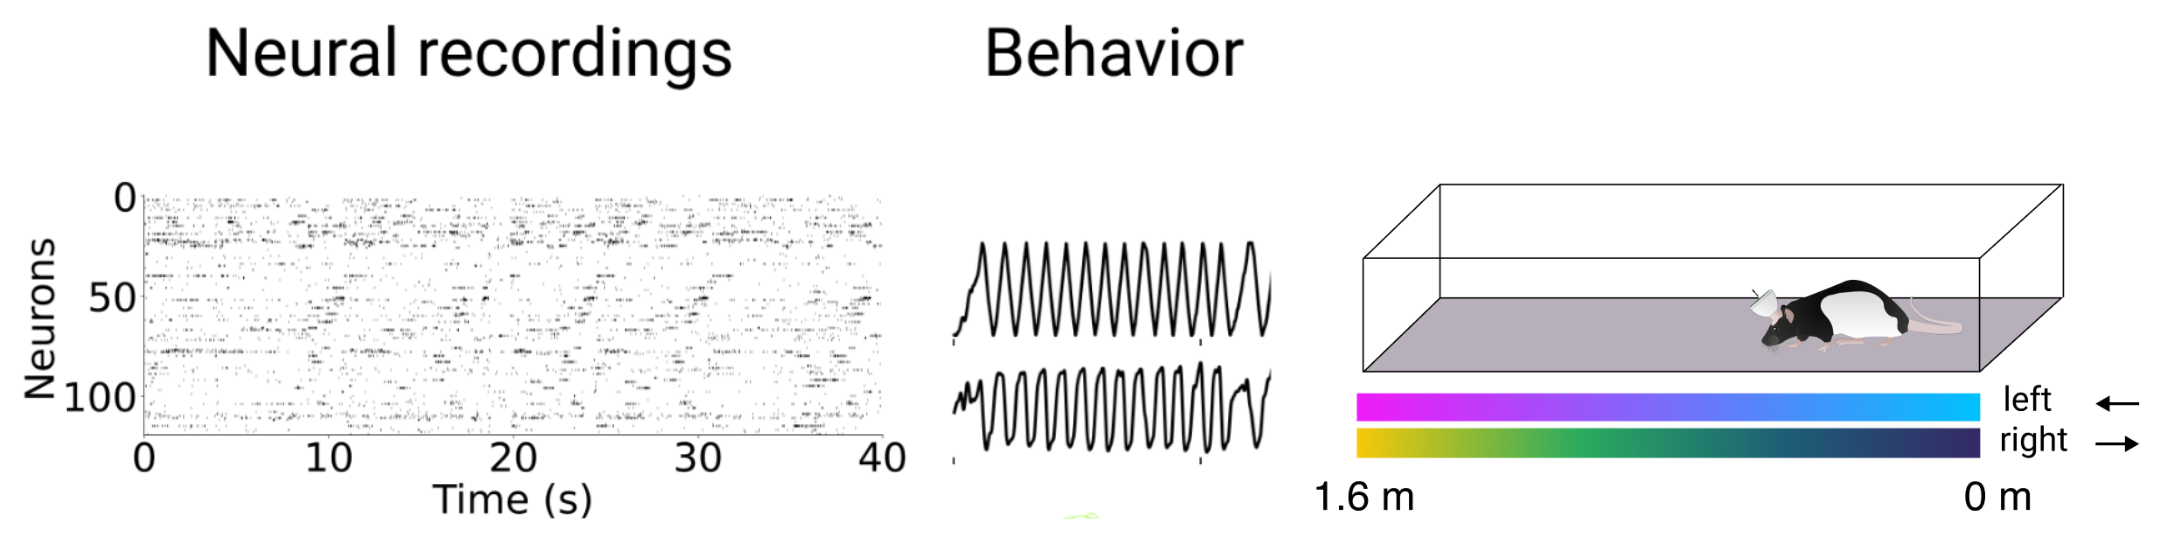

#### Credits

- Code adapted from https://github.com/pillowlab/GLMspiketraintutorial (MIT license, Copyright (c) 2016 pillowlab). This repo is also a great ressource for extended exercises around GLM fitting and beyond (e.g., MAP decoding).
- Visualizations from Dr. Cristina Savin and neuromatch academy
- The dataset was released by Grosmark, A.D., Long J. and Buzsáki, G. (2016); Recordings from hippocampal area CA1, PRE, during and POST novel spatial learning. CRCNS.org. http://dx.doi.org/10.6080/K0862DC5.
- This notebook was authored by Steffen Schneider.

### Setup

We need to download one auxiliary file with helper code, install `cebra` to interact with the dataset, and perform a few imports of packages. Then we're all set to dig into the code (no further data download needed!)

In [3]:
! wget -q https://gist.githubusercontent.com/stes/c090aa2c210e91e7b7b40d8ca9d434e9/raw/d8adf8eda5b2353e745734ce3d9f88e5c7bcb414/week5_utils.py

In [4]:
! pip install -q cebra

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.2/202.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.6 MB/s eta 0:00:00


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cebra
import cebra.datasets
from scipy.io import loadmat
import scipy.linalg

## Data Loading

In [6]:
from week5_utils import HippocampusDataset

data = HippocampusDataset()
data.all_spikes_binned.shape, data.position.shape, data.num_neurons

100%|██████████| 10.0M/10.0M [00:01<00:00, 7.68MB/s]


Download complete. Dataset saved in 'data/rat_hippocampus/achilles.jl'


((10178, 120), (10178,), 120)

120 neuronios, para cada neurónio temos 10178 data points; also temos a informação de a sua localização

In [7]:
print(data.get_neuron_spikes(52).shape) # get spikes for neuron with index 52

(10178,)


In [8]:
print(data.position.shape) # The position of the animal, as a 1D timeseries

(10178,)


In [9]:
print(data.direction.shape) # The direction (left or right) of the animal, as a 1D timeseries

(10178,)


In [10]:
print(data.sampling_rate_hz) # The sampling rate, in Hz

100.0


In [11]:
print(data.all_spikes_binned.shape) # An array containing all spike counts for all neurons

print(len(data), data.num_neurons) # Information about the length and number of neurons in the dataset

(10178, 120)
10178 120


## Data Visualization

We first visualize the data.

*Exercise: Adapt the code and compare the outputs of different neurons!*

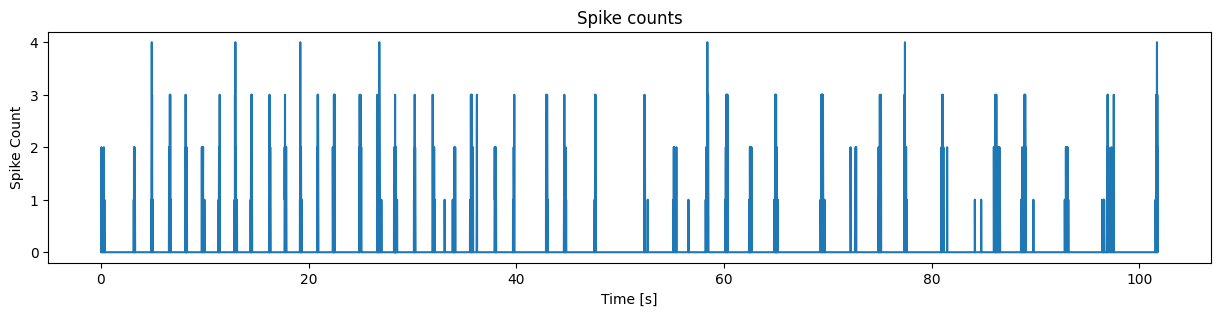

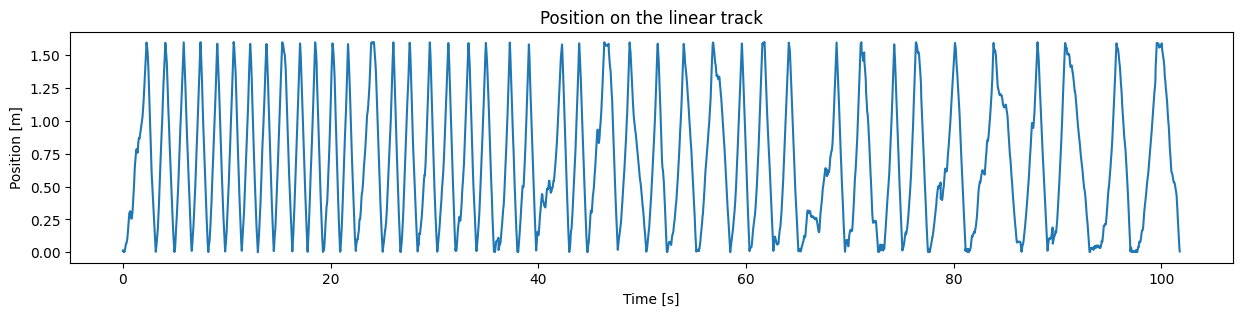

In [12]:
plt.figure(figsize=(15,3))
plt.plot(data.time, data.get_neuron_spikes(51))
plt.title("Spike counts")
plt.xlabel("Time [s]")
plt.ylabel("Spike Count")
plt.show()

plt.figure(figsize=(15,3))
plt.plot(data.time, data.position)
plt.title("Position on the linear track")
plt.xlabel("Time [s]")
plt.ylabel("Position [m]")
plt.show()

### Tuning curves

To explore the dataset, we plot the tuning curves (at which point in location does each neuron fire?) for all 120 neurons in the dataset

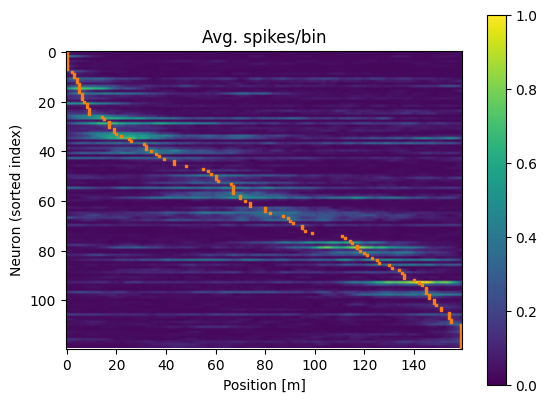

In [13]:
import scipy.signal

stim = data.position
neural = data.all_spikes_binned

counts, bins = np.histogram(data.position, bins = 160, range = (0,1.6))
stim_bin_idx = np.digitize(data.position, bins, right = False) - 1

avg = np.zeros((160, 120))
for i in range(160):
    avg[i, :] = neural[stim_bin_idx==i,:].mean(0)

# We smooth the data
avg = scipy.signal.savgol_filter(avg, axis = 0, window_length=11, polyorder=2)

#we sort the data so we see it in a regeression
max_bin = avg.argmax(axis = 0)
neuron_index = np.argsort(max_bin)

plt.title("Avg. spikes/bin")
plt.imshow(avg[:, neuron_index].T)
plt.scatter(max_bin[neuron_index], np.arange(120), marker='s', c = 'C1', s = 1)
plt.colorbar()
plt.xlabel("Position [m]")
plt.ylabel("Neuron (sorted index)")
plt.show()

## Design matrix

We will now construct the design matrix for the model. The model should consider outputs from different previous time-steps,

$$
y_t = x_t \theta_1 + x_{t-1} \theta_2 + \dots + x_{t-T} \theta_{T+1}
$$

To express this into a single matrix-vector product, we construct a vector containing all the $x_i$:

$$
\mathbf{x}_t = (x_t \dots x_{t-T})^\top
$$

and we re-arranges these vectors for every time step into a matrix.

Below is an example for such a matrix, with one $\mathbf{x}_t$ per row:

10
1
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 2.]
 [0. 0. 1. 2. 3.]
 [0. 1. 2. 3. 4.]
 [1. 2. 3. 4. 5.]
 [2. 3. 4. 5. 6.]
 [3. 4. 5. 6. 7.]
 [4. 5. 6. 7. 8.]
 [5. 6. 7. 8. 9.]]


Text(0.5, 1.0, 'Design Matrix $X$')

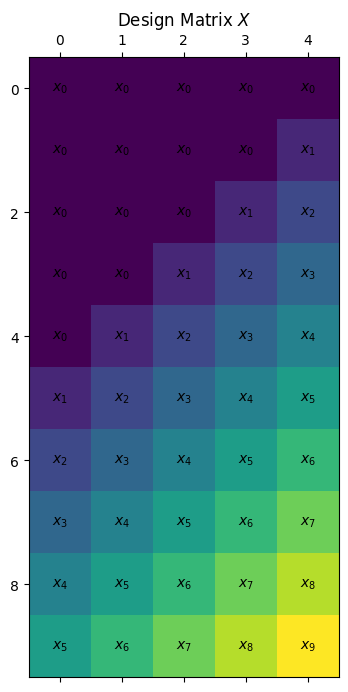

In [37]:
def build_design_matrix_ref(stim, filter_size):
    """For reference, this is a fast way to build the design matrix."""
    padded_stim = np.hstack((np.zeros(filter_size-1), stim))   # pad early bins of stimulus with zero
    design_mat = scipy.linalg.hankel(padded_stim[:-filter_size+1], stim[-filter_size:])
    return design_mat

# Here as an example stimulus we would like to convert into a design matrix
# For simplicity
stim = np.arange(10)
print(stim.shape[0])
print(stim[1])

matrix = build_design_matrix_ref(stim, filter_size = 5)
print(matrix)
plt.matshow(matrix)

for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        c = matrix[i, j]
        plt.gca().text(j, i, f"$x_{int(c)}$", va='center', ha='center')

plt.title("Design Matrix $X$")

In [60]:
matrix

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 3.],
       [0., 0., 1., 3., 4.],
       [0., 1., 3., 4., 5.],
       [1., 3., 4., 5., 5.],
       [3., 4., 5., 5., 5.]])

**Exercise: Write some code that constructs a design matrix like the one you see above, using standard numpy functions!**

In [34]:
def build_design_matrix(stim, filter_size):
    # TODO
   data_mat = np.zeros((stim.shape[0], filter_size))

   for i in range(0,filter_size):
    #first filter_size-i rowcells of i colums are filled with stim[0]
      data_mat[:filter_size - i, i] = 0
      #the remaining are filled with the remaining spots of stim
      for j in range(0, stim.shape[0] - (filter_size - i)):
        # data_mat[filter_size-i, i] = stim[j]
        data_mat[filter_size - i + j, i] = stim[j+1]

   return data_mat

In [33]:
### START SOLUTION
def build_design_matrix(stim, filter_size):
    """Exercise: Build the design matrix manually.

    This is the solution!
    """
    # pads the beginning of the stimulus with 0s
    #
    padded_stim = np.pad(stim, (filter_size-1,0), mode = "constant", constant_values = 0.)
    design_mat = np.zeros((len(stim),filter_size))
    for j in np.arange(len(stim)):
        design_mat[j] = padded_stim[j:j+filter_size] # grab last 'nkt' bins of stmiulus and insert into this row
    return design_mat
### END SOLUTION

In [36]:
stim = np.arange(10)
filter_size = 5
padded_stim = np.pad(stim, (filter_size-1,0), mode = "constant", constant_values = 0.)
design_mat = np.zeros((len(stim),filter_size))
print(padded_stim)

[0 0 0 0 0 1 2 3 4 5 6 7 8 9]


We can now also formally test if the function is correct, by running the code below.

In [35]:
def test_design_matrix(stim, filter_size):
    """A test that checks that the matrix construction is correct."""

    ours = build_design_matrix(stim, filter_size = filter_size)
    reference = build_design_matrix_ref(stim, filter_size = filter_size)

    # Check that the matrix construction is correct!
    assert ours.shape == (stim.shape[0], filter_size), f"{ours.shape} vs. {(stim.shape[0], filter_size)}"
    assert (ours == reference).all()

test_design_matrix(stim = np.arange(100), filter_size = 15)
test_design_matrix(stim = np.arange(4), filter_size = 3)

Let's now construct and visualize the design matrix on the real dataset:

<Figure size 1200x800 with 0 Axes>

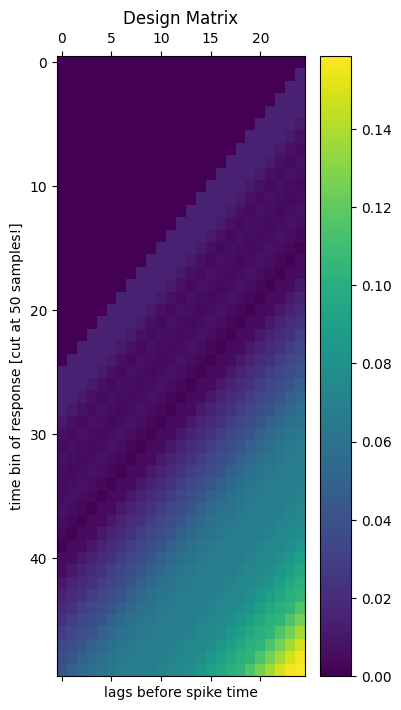

In [41]:
filter_size = 25
design_mat = build_design_matrix(data.position, filter_size=filter_size)
design_mat_ref = build_design_matrix_ref(data.position, filter_size=filter_size)

plt.figure(figsize=[12,8])
plt.matshow(design_mat[:50], aspect='auto')
plt.xlabel('lags before spike time')
plt.ylabel('time bin of response [cut at 50 samples!]')
plt.title("Design Matrix")
plt.colorbar()
plt.show();

In [43]:
design_mat.shape

(10178, 25)

In the visualization above, we cut the design matrix at 50 samples. We will now visualize the spike counts of a single neuron along with the design matrix containing all the regressors for our GLM model together.

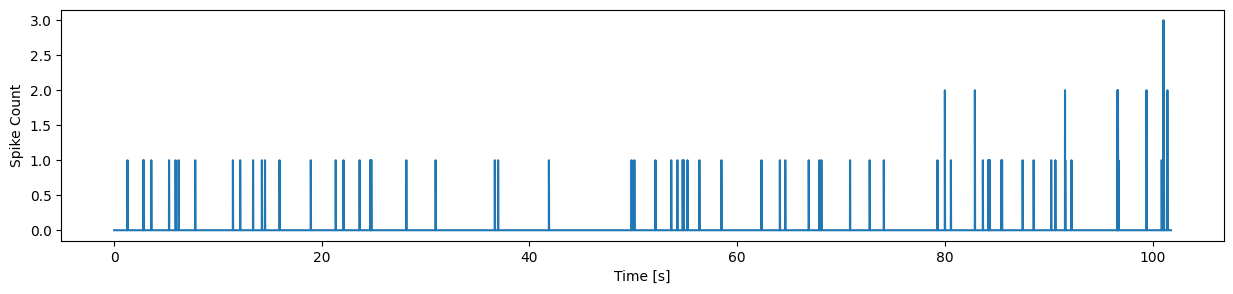

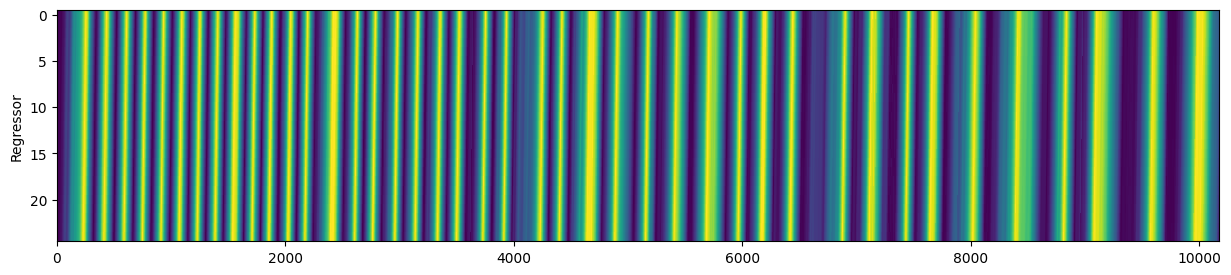

In [40]:
filter_size = 25
design_mat = build_design_matrix(stim = data.position, filter_size=filter_size)

plt.figure(figsize=(15,3))
plt.plot(data.time, neural[:,30])
plt.xlabel("Time [s]")
plt.ylabel("Spike Count")
plt.show()

plt.figure(figsize=(15,3))
plt.imshow(design_mat.T, aspect = "auto", interpolation="none")
plt.ylabel("Regressor")
plt.show()

## Fitting a linear model to the dataset

We now have a pre-processed dataset, consisting of the design matrix $X$, and a vector of output variables $\mathbf{y}$, which are the responses of a selected neuron.

As the first model, we will start with linear regression. The likelihood function assumes Gaussian variables for this model, and there is no nonlinearity. The outputs can be any real value:

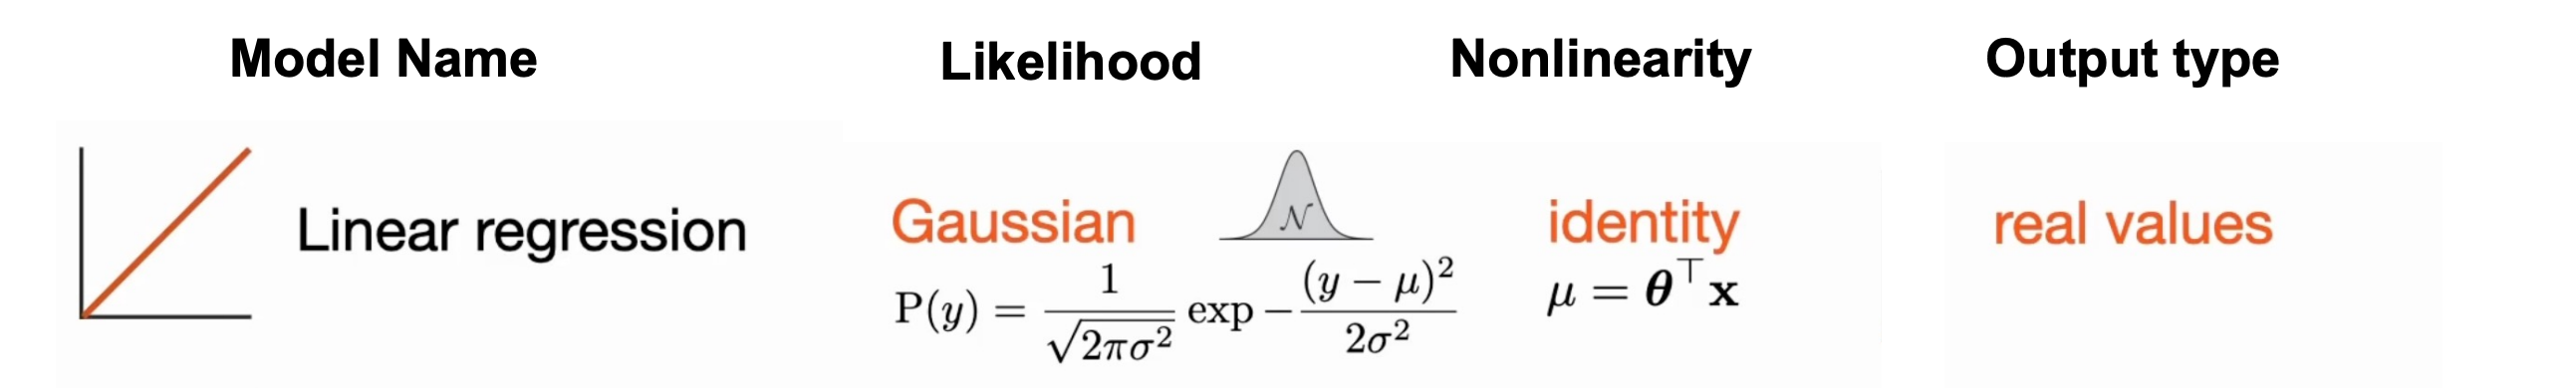

#### Implementation notes

Because we will implement multiple models in the course of this exercise, it is useful to think about the common structure between them. We will take [some inspiration](https://scikit-learn.org/stable/developers/develop.html) from the popular machine learning library scikit learn and construct models with a `fit()`, `predict()` and `score()` function.

We additionally define two properties, `filter_params` and `constant_params` which are the model parameters, denoted as $\theta$ above.

#### Implementing linear models

Linear models have a closed-form analytical solution, also known as the [Normal equations](https://en.wikipedia.org/wiki/Ordinary_least_squares#Normal_equations). Given our design matrix $X$ and the output vector $\mathbf{y}$, the model parameters can be estimated as

$$
\theta = (X^\top X)^{-1} X \mathbf{y}
$$

We here assume that $X$ is a $N \times d$ matrix with $N$ timesteps (observations) and $d$ features -- in our case, the time lags we constructed above. $\mathbf{y}$ is a $N$ dimensional vector, each entry describes the spike count at this particular time bin.

To generate a prediction with this model, we compute the matrix-vector product

$$
\hat{\mathbf y} = X \theta
$$

which is equivalent to computing $y_t = \theta^\top \mathbf{x}_t$ for every timestep $t$.

#### Exercises

- *Exercise 1: Implement the linear regression model*
- *Exercise 2: Extend the linear regression model with a bias term. Hint: the bias can be added by appending a row of ones to the design matrix X. You can look into the `np.stack` or `np.pad` functions to achieve this.*

In [48]:
from ctypes import BigEndianStructure
import sklearn.metrics

class LinearModel():

    def __init__(self, bias = False):
        self.bias = bias

    def fit(self, X, y):
        if self.bias:
          Xb = np.hstack((np.ones((len(X),1)), X))
        else:
          Xb = X

        # Write a function that fits the parameters of the linear model!

        self._params = np.linalg.inv(Xb.T @ Xb) @ (Xb.T @ y)

        y_pred = self.predict(X)
        self._score = sklearn.metrics.r2_score(y, y_pred)

        return self

    def predict(self, design_mat):
        return self.constant_params + design_mat @ self.filter_params

    def score(self):
        return self._score

    @property
    def filter_params(self):
        # TODO
        if self.bias:
          return self._params[1:]
        else:
          return self._params

    @property
    def constant_params(self):
        # TODO
        if self.bias:
          return self._params[0]
        else:
          return 0.

Let's test our implementation on some synthetic data.

In [49]:
def test_linear_model():
    """Unit test for linear regression models.

    The following unit test constructs a noise free dataset, which
    your linear regression model should be able to perfectly solve.

    If you cannot manage to get an R2 close to 1, double check your
    implementation.
    """

    X = np.random.normal(size=(10000, 10))
    y = (X @ np.random.normal(size=(10, 1))).squeeze()
    assert np.isclose(LinearModel().fit(X, y).score(), 1.0), \
        "R2 test failed for the linear model"

test_linear_model()

Did this work? Congrats, then your implementation is most likely correct!

Let's proceed with Exercise 2: Can you modify your implementation such that your model is able to accept a bias term?

*Hint: You need to concat a vector of ones to the design matrix before fitting!*

Modify your code such that your model accepts a parameter `bias = True`. Then proceed and run the next test!

In [50]:
def test_linear_model_with_bias():
    """Unit test for linear regression models.

    The following unit test constructs a noise free dataset, which
    your linear regression model should be able to perfectly solve.

    If you cannot manage to get an R2 close to 1, double check your
    implementation.
    """

    X = np.random.normal(size=(10000, 10))
    y = (X @ np.random.normal(size=(10, 1))).squeeze() + np.random.normal(size=(1,))
    model_score = LinearModel(bias = True).fit(X, y).score()

    assert np.isclose(model_score, 1.0), \
        f"R2 test failed when requiring a bias term. Please implement Exercise 2 before " \
        f"running this check! R2 score was: {model_score}"

test_linear_model_with_bias()

We can now apply our implementation to real data:

In [51]:
X = build_design_matrix(stim = data.position, filter_size=25)
y = data.get_neuron_spikes(51)
print(X.shape, y.shape)

model = LinearModel(bias = False).fit(X, y)
print("Score", model.score())

model_with_bias = LinearModel(bias = True).fit(X, y)
print("Score", model_with_bias.score())

(10178, 25) (10178,)
Score 0.028818834299112805
Score 0.08752277154303079


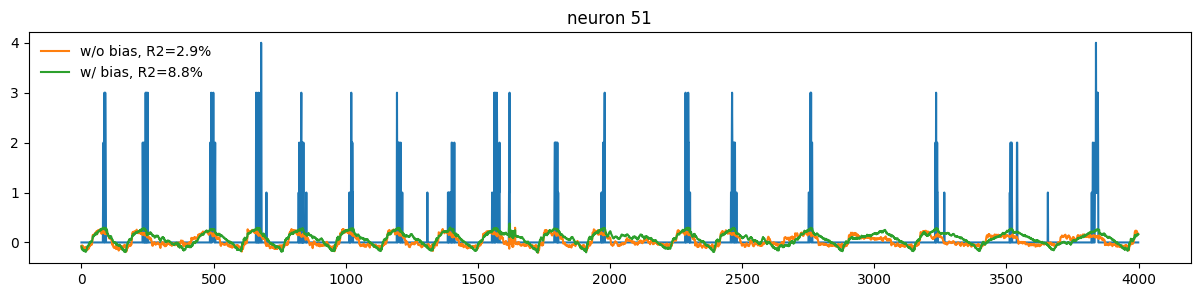

In [52]:
prediction = model.predict(X)
prediction_with_bias = model_with_bias.predict(X)
neuron_id = 51

plt.figure(figsize=(15,3))
plt.plot(y[2000:6000])
plt.plot(prediction[2000:6000], label = f"w/o bias, R2={model.score()*100:.1f}%")
plt.plot(prediction_with_bias[2000:6000], label = f"w/ bias, R2={model_with_bias.score()*100:.1f}%")
plt.title(f"neuron {neuron_id}")
plt.legend(frameon = False)
plt.show()

#### Conclusions

We can observe that the fit is not very good --- this is because we used a *linear* link function, and assumed a Gaussian distribution on the outputs.
The assumptions do not reflect our original data (binned spike counts) particularly well (although the general locations of spikes is captured by the predictions above).
In the next section, we extend our model, and use a non-linear link function, along with a Poisson distribution.

## GLM fitting with `statsmodels`

We will now fit GLMs using the `statsmodels` python library. The documentation can be found here: https://www.statsmodels.org/stable/glm.html

The components of the GLM are:
- the input variables: This is the design matrix we constructed in the previous step. The input has shape `timesteps, num_regressors`. The variables are also called *exogenous* variables, and abbreviated as `exog` in `statsmodels`.
- the output variables we would like to model: These are the binned spiking rates of the neuron we would like to fit. The output has shape `timesteps,` in our case (it is also possible to fit multivariate outputs, but we won't cover this during this tutorial). These variables are also called *endogenous* variables, and abbreviated as `endog` in `statsmodels`.
- the distribution to model, and the corresponding link function. In our case, we would like to fit a Poisson variable, and use a `log` link function. More details [here](https://www.statsmodels.org/stable/generated/statsmodels.genmod.families.family.Poisson.html#statsmodels.genmod.families.family.Poisson).

We will use this to implement the following model discussed in the lecture:

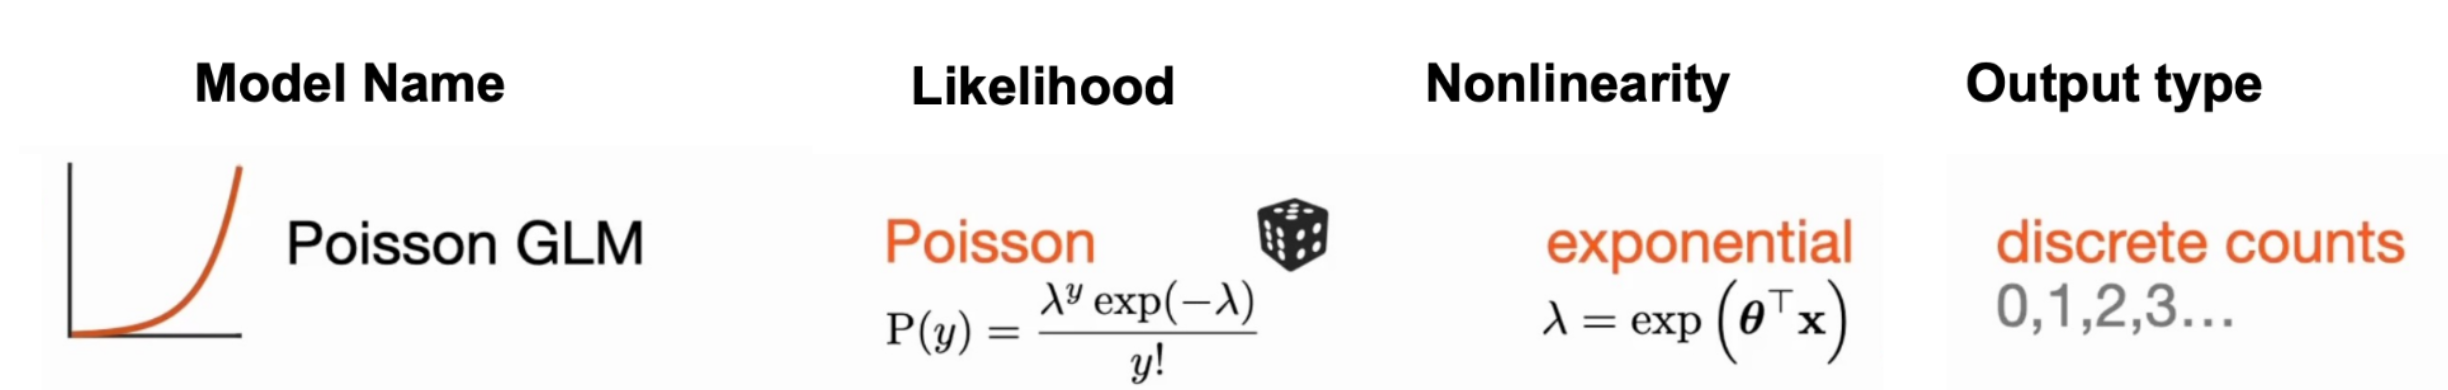

This model can no longer be solved analytically, and is instead fitted with iterative optimization algorithms which we will not cover in this notebook.

For the next exercise, adapt the GLM code below and implement the `predict()` function!

In [53]:
import statsmodels.api as sm


class GLMModel():
    """The class for our GLM model.

    We split the functionality into different parts:
    - fitting the model
    - computing the goodness of fit (the pseudo-R2)
    - making predictions on the dataset
    """

    def __init__(self):
        self.link_function = sm.families.links.Log()
        self.family = sm.families.Poisson(link = self.link_function)

    def fit(self, design_matrix, spikes):
        design_mat_offset = np.hstack((np.ones((len(design_matrix),1)), design_matrix))
        self._model = sm.GLM(
            endog=spikes, # dependent variable
            exog=design_mat_offset, # independent variable
            family=self.family
        )
        self._results = self._model.fit(max_iter=100, tol=1e-6, tol_criterion='params')
        return self

    def predict(self, design_mat):
        # TODO: Implement the fit function, by including the correct non-linearity.
        return np.exp(self.constant_params + design_mat @ self.filter_params)

    def score(self):
        return self._results.pseudo_rsquared(kind='mcf')

    @property
    def filter_params(self):
        return self._results.params[1:]

    @property
    def constant_params(self):
        return self._results.params[0]


As before, let's test our implementation with a unit test!

In [54]:
def test_poisson_model():
    """Unit test for Poisson regression models.

    A variant of the unit test we used before, now for
    GLM models.
    """

    X = np.random.normal(size=(10000, 100))
    y = (X @ np.random.normal(size=(100, 1))).squeeze()
    y = np.exp(y)
    model_score = GLMModel().fit(X, y).score()
    assert model_score > 0.99, \
        f"R2 test failed for the Poisson GLM, R2: {model_score}"

test_poisson_model()

Next, let's apply our implementation to real data and check the pseudo-R2 score:

In [55]:
glm = GLMModel()
glm.fit(design_mat, data.get_neuron_spikes(51))
print("Score", glm.score())

Score 0.47015833715225297


We can now fit GLMs on the full dataset!

In [56]:
import tqdm

prediction = np.zeros_like(data.all_spikes_binned)
filters = []
r2 = np.zeros(neural.shape[1])

r2[:] = float("nan")
prediction[:] = float("nan")

glm = GLMModel()

for neuron_id in tqdm.tqdm(range(data.num_neurons)):
    try:
        glm.fit(design_mat, data.get_neuron_spikes(neuron_id))
    except ValueError:
        print(f"Error fitting neuron {neuron_id}. Skipping")
        continue
    r2[neuron_id] = glm.score()
    prediction[:,neuron_id] = glm.predict(design_mat)

 32%|███▎      | 39/120 [00:10<00:19,  4.16it/s]/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/families/family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
 34%|███▍      | 41/120 [00:10<00:12,  6.12it/s]

Error fitting neuron 39. Skipping


100%|██████████| 120/120 [00:25<00:00,  4.63it/s]


### Results overview (histogram of pseudo-R2 values)

To get an overview, we plot the pseudo-R2 values of all neurons across the dataset.

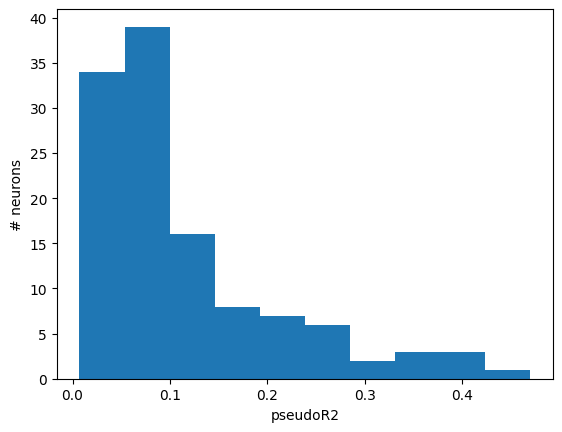

In [57]:
plt.hist(r2)
plt.ylabel("# neurons")
plt.xlabel("pseudoR2")
plt.show()

Next, we visualize the predictions for the two best-fitted and the two worst-fitted neurons.

51


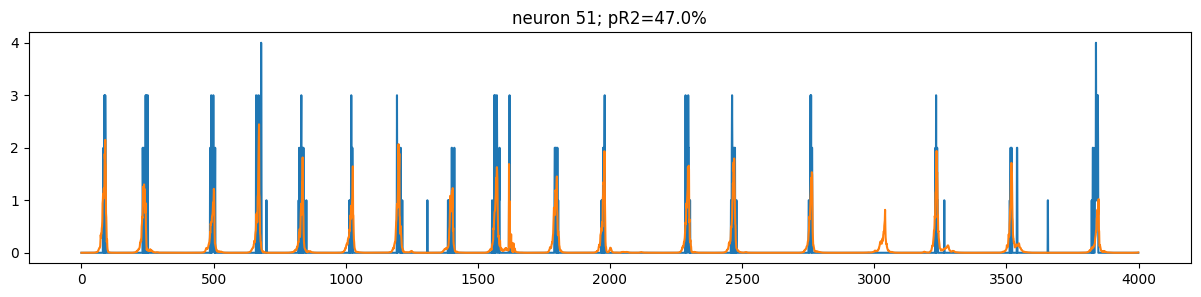

84


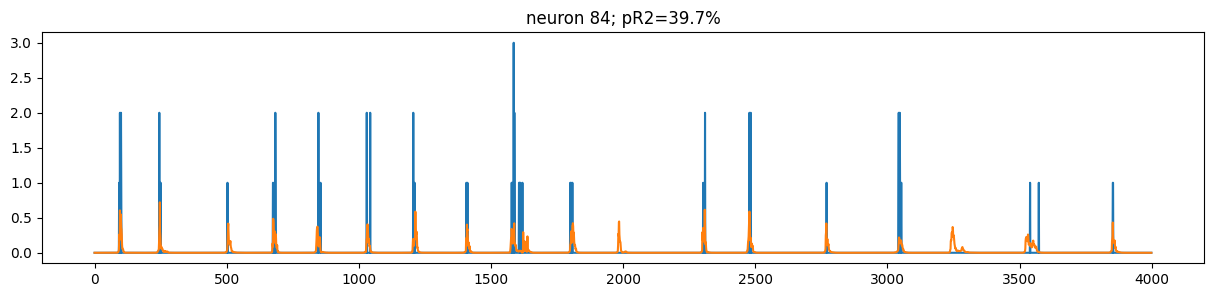

14


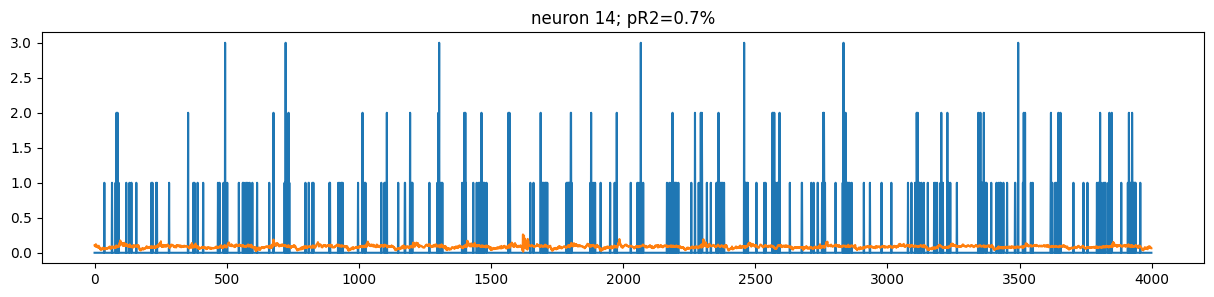

16


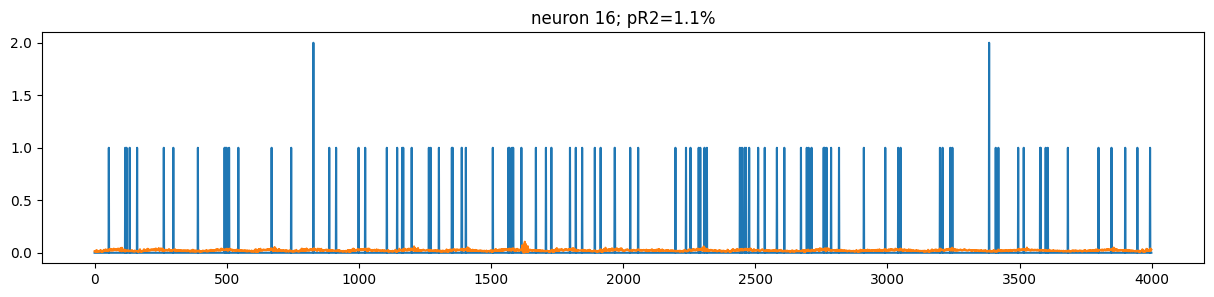

In [58]:
for neuron_id in np.argsort(-r2)[:2]:
    print(neuron_id)
    binned_spikes = data.get_neuron_spikes(neuron_id)
    plt.figure(figsize=(15,3))
    plt.plot(binned_spikes[2000:6000])
    plt.plot(prediction[2000:6000,neuron_id])
    plt.title(f"neuron {neuron_id}; pR2={r2[neuron_id]*100:.1f}%")
    plt.show()

for neuron_id in np.argsort(r2)[:2]:
    print(neuron_id)
    binned_spikes = data.get_neuron_spikes(neuron_id)
    plt.figure(figsize=(15,3))
    plt.plot(binned_spikes[2000:6000])
    plt.plot(prediction[2000:6000,neuron_id])
    plt.title(f"neuron {neuron_id}; pR2={r2[neuron_id]*100:.1f}%")
    plt.show()

# Optional exercise: Extending the Design Matrix to include spike history

The following cells contain optional material to improve our predictions by including spike count history. For this, the design matrix $X$ is extended to also include a *time-shifted* version of the spike counts $\mathbf{y}$.

To predict $y_t$, we will use again the position information $x_t, x_{t-1}, ...$ as above, but additionally include information about the spike history, $y_{t-1}, y_{t-2}, ...$.

We will re-use our code above, and extend it to add the second part.
The extended version of the design matrix construction function looks like this:

In [59]:
def build_design_matrix_with_history(stim, spikes, filter_size, history_timesteps):
    # Build design matrix as for part I
    design_mat_stim = build_design_matrix(stim, filter_size=filter_size)

    # Build spike-history design matrix
    padded_spikes = np.hstack((np.zeros(history_timesteps), spikes_binned[:-1]))

    # SUPER important: note that this doesn't include the spike count for the
    # bin we're predicting? The spike train is shifted by one bin (back in
    # time) relative to the stimulus design matrix
    design_mat_spikes = scipy.linalg.hankel(padded_spikes[:-history_timesteps+1], padded_spikes[-history_timesteps:])

    return np.concatenate((design_mat_stim, design_mat_spikes), axis=1)

And we can visualize the different parts of the matrix:

<Figure size 640x480 with 0 Axes>

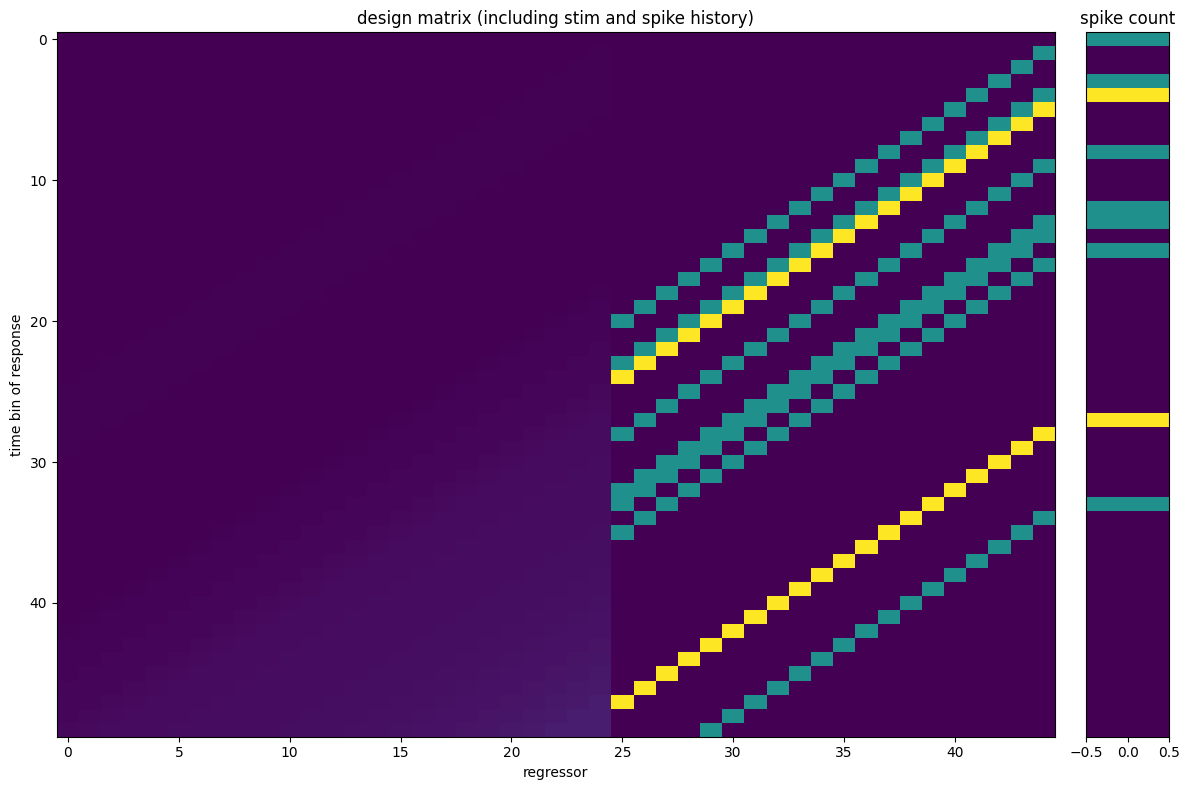

In [60]:
cell_idx = 51
spikes_binned = data.get_neuron_spikes(cell_idx)
stim = data.position
design_matrix = build_design_matrix_with_history(stim, spikes_binned, filter_size = 25, history_timesteps=20)

plt.clf()
fig = plt.figure(figsize=[12,8])
plt.subplot(1,10,(1,9))
plt.imshow(design_matrix[:50], aspect='auto', interpolation='nearest')
plt.xlabel('regressor')
plt.ylabel('time bin of response')
plt.title('design matrix (including stim and spike history)')
plt.subplot(1,10,10)
plt.imshow(spikes_binned[:50,np.newaxis], aspect='auto', interpolation='nearest')
plt.yticks(ticks=[], labels=[])
plt.title('spike count')
plt.tight_layout()
plt.show()

We can also again visualize the spike counts over time, alongside the design matrix.

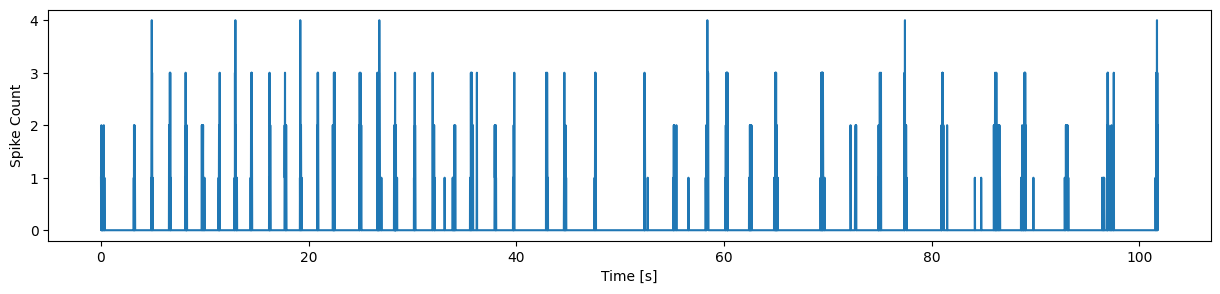

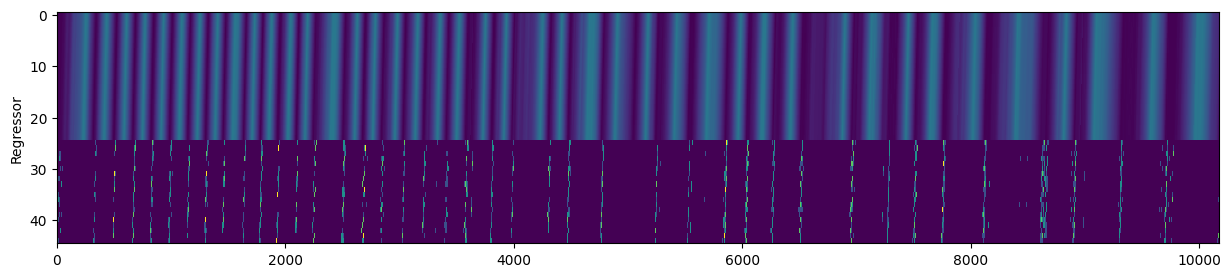

In [61]:
cell_idx = 51
spikes_binned = data.get_neuron_spikes(cell_idx)
stim = data.position
design_matrix = build_design_matrix_with_history(stim, spikes_binned, filter_size = 25, history_timesteps=20)

plt.figure(figsize=(15,3))
plt.plot(data.time, spikes_binned)
plt.xlabel("Time [s]")
plt.ylabel("Spike Count")
plt.show()

plt.figure(figsize=(15,3))
plt.imshow(design_matrix.T, aspect = "auto", interpolation="none")
plt.ylabel("Regressor")
plt.show()

Finally, we compare the predictions we obtain with the previous design matrix to this extended version.

*Exercise: How do variations in the `filter_size` and the number of `history_timesteps` influence the result?*

Score, w/o history 0.14494942572049385
Score, w/ history  0.25719755432231106


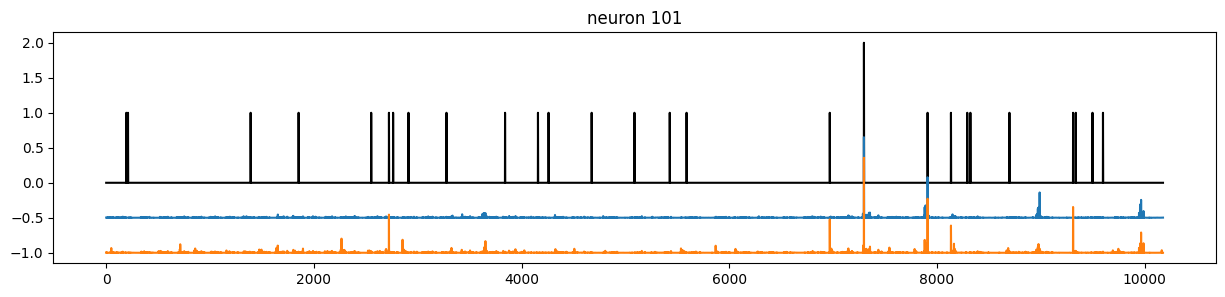

In [62]:
cell_idx = 101
spikes = data.get_neuron_spikes(cell_idx)
stim = data.position

design_matrix_standard = build_design_matrix(stim, filter_size = 50)
design_matrix_history = build_design_matrix_with_history(stim, spikes_binned, filter_size = 50, history_timesteps=50)

glm = GLMModel()
glm.fit(design_matrix_standard, spikes)
pred_wo_history = glm.predict(design_matrix_standard)
print("Score, w/o history", glm.score())

glm.fit(design_matrix_history, spikes)
pred_w_history = glm.predict(design_matrix_history)
print("Score, w/ history ", glm.score())

plt.figure(figsize=(15,3))
plt.plot(spikes, c = "black")
plt.plot(pred_wo_history - .5)
plt.plot(pred_w_history - 1.0)
plt.title(f"neuron {cell_idx}")
plt.show()